## Olivetti Faces データセットを使って、顔写真からどの人であるかを判断するCNNを作ってみよう

In [ ]:
# 必要なライブラリなどのインポート
%matplotlib inline
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from sklearn import datasets

In [ ]:
# fetch_olivetti_facesデータセットを読み込む
faces = datasets.fetch_olivetti_faces()
# データの形状を確認（400人枚の顔データ／64*64=4096ピクセルデータという意味）
faces.data.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


(400, 4096)

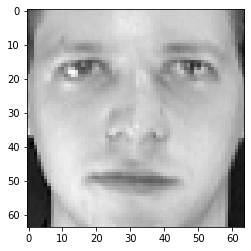

In [ ]:
# データセットの内容をMatplot上で表示してみる
# 0番目データを表示
plt.imshow(faces.data[0].reshape(64, 64), cmap="gray")
plt.show() 

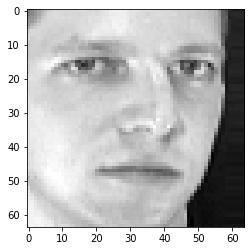

In [ ]:
# 1番目のデータを同様にMatplot上に表示してみよう
plt.imshow(faces.data[1].reshape(64, 64), cmap="gray")
plt.show()

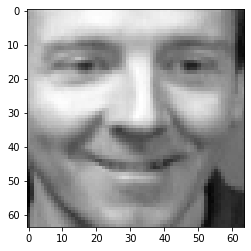

In [ ]:
# 20番目のデータをMatplot上に表示してみよう
plt.imshow(faces.data[20].reshape(64, 64), cmap="gray")
plt.show()

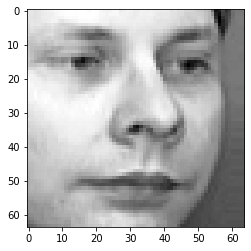

3


In [ ]:
# 39番目のデータをMatplot上に表示してみよう
plt.imshow(faces.data[39].reshape(64, 64), cmap="gray")
plt.show() 

# 正解データはラベルになっている。
print(faces.target[39])

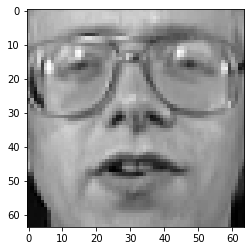

1


In [ ]:
# 10番目のデータをMatplot上に表示してみよう
plt.imshow(faces.data[10].reshape(64, 64), cmap="gray")
plt.show()

# 10番目のデータの正解データも表示する
print(faces.target[10])

In [ ]:
# 正解データの形状を確認
faces.target.shape

(400,)

In [ ]:
# 正解データの種類を確認
np.unique(faces.target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39])

## つまり、Olivetti Faces には 400種類の顔データ、0～39までのラベル付けされた顔（＝40人分の顔）データが入っている

このデータを使って、テキストのソースコードを改変し、顔データから正しいラベル（番号）を検出するCNNを実装してみよう。

Epoch:0/50 Error_train:4.740148895468758 Error_test:3.146382747997698
Epoch:10/50 Error_train:0.012269106482928888 Error_test:0.2619528587938191
Epoch:20/50 Error_train:0.0035967309948280344 Error_test:0.24027805835734262
Epoch:30/50 Error_train:0.0021825237612452656 Error_test:0.23722577428576805
Epoch:40/50 Error_train:0.00143190902814868 Error_test:0.2360319081408207


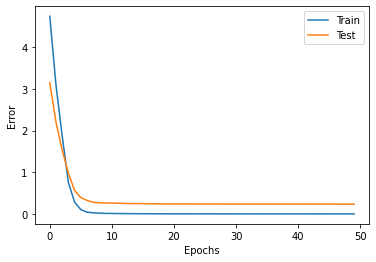

Accuracy Train: 100.0% Accuracy Test: 93.28358208955224%


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# -- 手書き文字データセットの読み込み --
digits_data = datasets.fetch_olivetti_faces()
input_data = faces.data
correct = faces.target
n_data = len(correct)

# -- 入力データの標準化 --
ave_input = np.average(input_data)
std_input = np.std(input_data)
input_data = (input_data - ave_input) / std_input

# -- 正解をone-hot表現に --
# ■■■■①
# 分類で出力する値が40通りあるから
correct_data = np.zeros((n_data, 40))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0

# -- 訓練データとテストデータ --
index = np.arange(n_data)
index_train = index[index%3 != 0]
index_test = index[index%3 == 0]

input_train = input_data[index_train, :]  # 訓練 入力
correct_train = correct_data[index_train, :]  # 訓練 正解
input_test = input_data[index_test, :]  # テスト 入力
correct_test = correct_data[index_test, :]  # テスト 正解

n_train = input_train.shape[0]  # 訓練データのサンプル数
n_test = input_test.shape[0]  # テストデータのサンプル数

# -- 各設定値 --
# ■■■■②～④
# 64×64ピクセルの画像だから
img_h = 64  # 入力画像の高さ
img_w = 64  # 入力画像の幅
# 入力画像が一色だから
# 一色＝白黒＝1チャネル
img_ch = 1  # 入力画像のチャンネル数

wb_width = 0.1  # 重みとバイアスの広がり具合
eta = 0.01  # 学習係数
epoch = 50
batch_size = 8
interval = 10  # 経過の表示間隔
n_sample = 200  # 誤差計測のサンプル数

# -- im2col --
def im2col(images, flt_h, flt_w, out_h, out_w, stride, pad):
   
    n_bt, n_ch, img_h, img_w = images.shape
    
    img_pad = np.pad(images, [(0,0), (0,0), (pad, pad), (pad, pad)], "constant")
    cols = np.zeros((n_bt, n_ch, flt_h, flt_w, out_h, out_w))

    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            cols[:, :, h, w, :, :] = img_pad[:, :, h:h_lim:stride, w:w_lim:stride]

    cols = cols.transpose(1, 2, 3, 0, 4, 5).reshape(n_ch*flt_h*flt_w, n_bt*out_h*out_w)
    return cols

# -- col2im --
def col2im(cols, img_shape, flt_h, flt_w, out_h, out_w, stride, pad):
 
    n_bt, n_ch, img_h, img_w = img_shape
    
    cols = cols.reshape(n_ch, flt_h, flt_w, n_bt, out_h, out_w, ).transpose(3, 0, 1, 2, 4, 5)
    images = np.zeros((n_bt, n_ch, img_h+2*pad+stride-1, img_w+2*pad+stride-1))
    
    for h in range(flt_h):
        h_lim = h + stride*out_h
        for w in range(flt_w):
            w_lim = w + stride*out_w
            images[:, :, h:h_lim:stride, w:w_lim:stride] += cols[:, :, h, w, :, :]

    return images[:, :, pad:img_h+pad, pad:img_w+pad]

# -- 畳み込み層 --
class ConvLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # n_flt:フィルタ数, flt_h:フィルタ高さ, flt_w:フィルタ幅
    # stride:ストライド幅, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad):

        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad)
        
        # フィルタとバイアスの初期値
        self.w = wb_width * np.random.randn(n_flt, x_ch, flt_h, flt_w)
        self.b = wb_width * np.random.randn(1, n_flt)
        
        # 出力画像のサイズ
        self.y_ch = n_flt  # 出力チャンネル数
        self.y_h = (x_h - flt_h + 2*pad) // stride + 1  # 出力高さ
        self.y_w = (x_w - flt_w + 2*pad) // stride + 1  # 出力幅
 
        # AdaGrad用
        self.h_w = np.zeros((n_flt, x_ch, flt_h, flt_w)) + 1e-8
        self.h_b = np.zeros((1, n_flt)) + 1e-8
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像とフィルタを行列に変換
        self.cols = im2col(x, flt_h, flt_w, y_h, y_w, stride, pad)
        self.w_col = self.w.reshape(n_flt, x_ch*flt_h*flt_w)
        
        # 出力の計算: 行列積、バイアスの加算、活性化関数
        u = np.dot(self.w_col, self.cols).T + self.b
        self.u = u.reshape(n_bt, y_h, y_w, y_ch).transpose(0, 3, 1, 2)
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0]
        x_ch, x_h, x_w, n_flt, flt_h, flt_w, stride, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # delta
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        delta = delta.transpose(0,2,3,1).reshape(n_bt*y_h*y_w, y_ch)
        
        # フィルタとバイアスの勾配
        grad_w = np.dot(self.cols, delta)
        self.grad_w = grad_w.T.reshape(n_flt, x_ch, flt_h, flt_w)
        self.grad_b = np.sum(delta, axis=0)
        
        # 入力の勾配
        grad_cols = np.dot(delta, self.w_col)
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols.T, x_shape, flt_h, flt_w, y_h, y_w, stride, pad)
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- プーリング層 --
class PoolingLayer:
    
    # n_bt:バッチサイズ, x_ch:入力チャンネル数, x_h:入力画像高さ, x_w:入力画像幅
    # pool:プーリング領域のサイズ, pad:パディング幅
    # y_ch:出力チャンネル数, y_h:出力高さ, y_w:出力幅
    
    def __init__(self, x_ch, x_h, x_w, pool, pad):
        
        # パラメータをまとめる
        self.params = (x_ch, x_h, x_w, pool, pad)
        
        # 出力画像のサイズ
        self.y_ch = x_ch  # 出力チャンネル数
        self.y_h = x_h//pool if x_h%pool==0 else x_h//pool+1  # 出力高さ
        self.y_w = x_w//pool if x_w%pool==0 else x_w//pool+1  # 出力幅
        
    def forward(self, x):
        n_bt = x.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 入力画像を行列に変換
        cols = im2col(x, pool, pool, y_h, y_w, pool, pad)
        cols = cols.T.reshape(n_bt*y_h*y_w*x_ch, pool*pool)
        
        # 出力の計算: Maxプーリング
        y = np.max(cols, axis=1)
        self.y = y.reshape(n_bt, y_h, y_w, x_ch).transpose(0, 3, 1, 2)
        
        # 最大値のインデックスを保存
        self.max_index = np.argmax(cols, axis=1)
    
    def backward(self, grad_y):
        n_bt = grad_y.shape[0] 
        x_ch, x_h, x_w, pool, pad = self.params
        y_ch, y_h, y_w = self.y_ch, self.y_h, self.y_w
        
        # 出力の勾配の軸を入れ替え
        grad_y = grad_y.transpose(0, 2, 3, 1)
        
        # 行列を作成し、各列の最大値であった要素にのみ出力の勾配を入れる
        grad_cols = np.zeros((pool*pool, grad_y.size))
        grad_cols[self.max_index.reshape(-1), np.arange(grad_y.size)] = grad_y.reshape(-1) 
        grad_cols = grad_cols.reshape(pool, pool, n_bt, y_h, y_w, y_ch)
        grad_cols = grad_cols.transpose(5,0,1,2,3,4) 
        grad_cols = grad_cols.reshape( y_ch*pool*pool, n_bt*y_h*y_w)

        # 入力の勾配
        x_shape = (n_bt, x_ch, x_h, x_w)
        self.grad_x = col2im(grad_cols, x_shape, pool, pool, y_h, y_w, pool, pad)
         

# -- 全結合層の継承元 --
class BaseLayer:
    # n_upper = 重み(上の層)、n = バイアス(下の層)
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n)
        self.b = wb_width * np.random.randn(n)

        self.h_w = np.zeros(( n_upper, n)) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
# -- 全結合 中間層 --
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) # ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

# -- 全結合 出力層 --
class OutputLayer(BaseLayer):     
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1).reshape(-1, 1) # ソフトマックス関数

    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 


# -- 各層の初期化 --
# 畳み込み層                        ストライドの↓　↓パディングの幅
cl_1 = ConvLayer(img_ch, img_h, img_w, 10, 3, 3, 1, 1)
#                          フィルタの数↑ ↑ ↑フィルタの大きさ 
# プーリング層               
pl_1 = PoolingLayer(cl_1.y_ch, cl_1.y_h, cl_1.y_w, 2, 0)

n_fc_in = pl_1.y_ch * pl_1.y_h * pl_1.y_w

ml_1 = MiddleLayer(n_fc_in, 100)
# ■■■■⑤
# なぜ100と⑤の数になるのか必ず理解しよう
# 出力層の数が40になるため
ol_1 = OutputLayer(100, 40)
# OutputLayer:出力層のこと
# この出力層の出力値→40種類の数を分類したいので40になる

# -- 順伝播 --
def forward_propagation(x):
    n_bt = x.shape[0]
    
    images = x.reshape(n_bt, img_ch, img_h, img_w)
    cl_1.forward(images)
    pl_1.forward(cl_1.y)
    
    fc_input = pl_1.y.reshape(n_bt, -1)   
    ml_1.forward(fc_input)
    ol_1.forward(ml_1.y)

# -- 逆伝播 --
def backpropagation(t):
    n_bt = t.shape[0]
    
    ol_1.backward(t)
    ml_1.backward(ol_1.grad_x)
    
    grad_img = ml_1.grad_x.reshape(n_bt, pl_1.y_ch, pl_1.y_h, pl_1.y_w)
    pl_1.backward(grad_img)
    cl_1.backward(pl_1.grad_x)

# -- 重みとバイアスの更新 --
def uppdate_wb():
    cl_1.update(eta)
    ml_1.update(eta)
    ol_1.update(eta)

# -- 誤差を計算 --
def get_error(t, batch_size):
    return -np.sum(t * np.log(ol_1.y + 1e-7)) / batch_size # 交差エントロピー誤差

# -- サンプルを順伝播 --
def forward_sample(inp, correct, n_sample):
    index_rand = np.arange(len(correct))
    np.random.shuffle(index_rand) 
    index_rand = index_rand[:n_sample]
    x = inp[index_rand, :]
    t = correct[index_rand, :]
    forward_propagation(x)
    return x, t

    
# -- 誤差の記録用 --
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

# -- 学習と経過の記録 --
n_batch = n_train // batch_size
for i in range(epoch):

    # -- 誤差の計測 -- 
    x, t = forward_sample(input_train, correct_train, n_sample)
    error_train = get_error(t, n_sample)
    
    x, t = forward_sample(input_test, correct_test, n_sample) 
    error_test = get_error(t, n_sample)
    
    # -- 誤差の記録 -- 
    train_error_x.append(i)
    train_error_y.append(error_train) 
    test_error_x.append(i)
    test_error_y.append(error_test) 
    
    # -- 経過の表示 --
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_test:" + str(error_test))
    
    # -- 学習 -- 
    index_rand = np.arange(n_train)
    np.random.shuffle(index_rand)   
    for j in range(n_batch):
        
        mb_index = index_rand[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]

        forward_propagation(x)
        backpropagation(t)        
        uppdate_wb() 
            
    
# -- 誤差の記録をグラフ表示 -- 
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

# -- 正解率の測定 -- 
x, t = forward_sample(input_train, correct_train, n_train) 
count_train = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

x, t = forward_sample(input_test, correct_test, n_test) 
count_test = np.sum(np.argmax(ol_1.y, axis=1) == np.argmax(t, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

In [ ]:
# 内容も表示
print('サンプルに代入する値：',index_test[:15])

samples = input_test[:15]
forward_propagation(samples)

print(ol_1.y)
print(correct_test[:15])

サンプルに代入する値： [ 0  3  6  9 12 15 18 21 24 27 30 33 36 39 42]
[[9.49204506e-01 1.32071111e-07 3.46500829e-06 3.37163629e-07
  8.11824632e-07 1.50791456e-03 2.77175100e-05 1.38641676e-02
  5.24650196e-12 1.12455752e-04 5.42567926e-05 9.27533445e-06
  8.92287162e-06 1.32315726e-06 1.31293226e-07 2.36887703e-02
  1.74445528e-08 1.05303406e-02 9.05252530e-06 1.31550445e-07
  4.68696015e-12 4.72078153e-14 2.66233012e-05 1.13575950e-06
  1.02623485e-06 2.56868734e-08 1.31799512e-05 7.94644462e-08
  1.22513536e-09 4.22219182e-06 2.81035199e-14 8.66312149e-05
  2.53045449e-13 1.11808392e-11 3.11753527e-08 8.43243831e-04
  1.64215810e-09 1.09000439e-09 2.13646097e-09 6.53959832e-08]
 [3.69471635e-01 3.44589105e-09 2.28707633e-03 3.39985051e-04
  4.61408380e-02 2.66517167e-06 6.03029690e-05 4.32410305e-10
  2.42342661e-06 1.03314947e-04 5.93764117e-05 2.89826558e-02
  5.14089519e-03 2.46640017e-05 6.13216711e-08 5.93770464e-05
  3.14172670e-02 5.18140078e-12 1.75498868e-08 1.40338382e-03
  1.220788

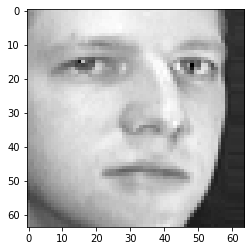

0


In [ ]:
# 念のため4番目～6番目が同一人物か確認
plt.imshow(faces.data[4].reshape(64, 64), cmap="gray")
plt.show() 
print(faces.target[4])

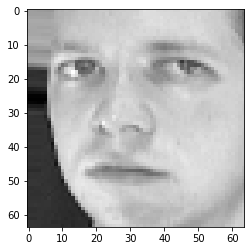

0


In [ ]:
plt.imshow(faces.data[5].reshape(64, 64), cmap="gray")
plt.show() 
print(faces.target[5])

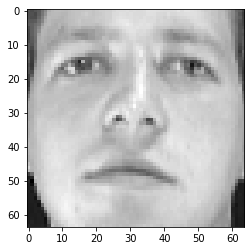

0


In [ ]:
plt.imshow(faces.data[6].reshape(64, 64), cmap="gray")
plt.show() 
print(faces.target[6])

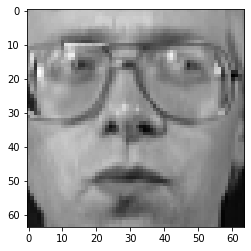

1


In [ ]:
plt.imshow(faces.data[12].reshape(64, 64), cmap="gray")
plt.show() 
print(faces.target[12])